# License 
***
Copyright 2017 J. Patrick Hall, phall@h2o.ai & Navdeep Gill, navdeep@h2o.ai

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Monotonic Gradient Boosting using XGBoost 
***
http://xgboost.readthedocs.io/en/latest//tutorials/monotonic.html

Monotonicity is an important facet of intepretability. Monotonicity constraints ensure that the modeled relationship between inputs and the target move in only direction, i.e. as an input increases the target can only increase or as input increases the target can only decrease. Such monotonic relationships are usually easier to explain and understand than non-monotonic relationships. 

## Preliminaries: imports, start h2o, load and clean data 

In [1]:
# imports
import h2o
from h2o.estimators.xgboost import H2OXGBoostEstimator
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import xgboost as xgb

/home/lingyao/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
# start h2o
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_03-Ubuntu"; OpenJDK Runtime Environment (build 1.8.0_03-Ubuntu-8u77-b03-3ubuntu3-b03); OpenJDK 64-Bit Server VM (build 25.03-b03, mixed mode)
  Starting server from /home/lingyao/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpaad_ng7t
  JVM stdout: /tmp/tmpaad_ng7t/h2o_lingyao_started_from_python.out
  JVM stderr: /tmp/tmpaad_ng7t/h2o_lingyao_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,6 days
H2O cluster name:,H2O_from_python_lingyao_o0iyux
H2O cluster total nodes:,1
H2O cluster free memory:,3.422 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


#### Load and prepare data for modeling

In [3]:
# load clean data
path = '../data/train.csv'
frame = h2o.import_file(path=path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
# assign target and inputs
y = 'SalePrice'
X = [name for name in frame.columns if name not in [y, 'Id']]

#### Monotonic constraints are easier to understand for numeric inputs without missing values

In [5]:
# determine column types
# impute
reals, enums = [], []
for key, val in frame.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        else: 
            reals.append(key)
            
_ = frame[reals].impute(method='median')

In [6]:
# split into training and validation
train, valid = frame.split_frame([0.7], seed=12345)

In [7]:
# for convenience create a tuple for xgboost monotone_constraints parameter
# in this data, most inputs increase with increasing home prices
# xgboost does allow for positive, negative, and no constraints in a model
mono_constraints = tuple(int(i) for i in np.ones(shape=(int(1), len(reals))).tolist()[0])

## Train a monotonic predictive model
In this XGBoost GBM all the modeled relationships between the inputs and the target are forced to be monotonically increasing.

#### Log transform for better regression results and easy RMSLE in XGBoost

SalePrice
12.2477
12.109
12.3172


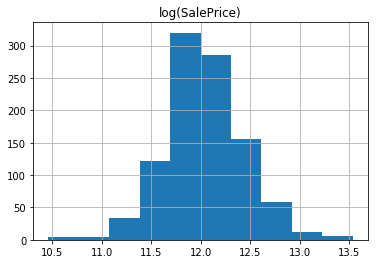

In [8]:
# Check log transform - looks good
%matplotlib inline
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
valid['SalePrice'] = valid['SalePrice'].log()
print(train[0:3, 'SalePrice'])

#### Train XGBoost with monotonicity Constraints

In [9]:
ave_y = train['SalePrice'].mean()[0]

# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas data frames 
dtrain = xgb.DMatrix(train.as_data_frame()[reals],
                      train.as_data_frame()['SalePrice'])
dvalid = xgb.DMatrix(valid.as_data_frame()[reals],
                      valid.as_data_frame()['SalePrice'])

# tuning parameters
params = {
    'objective': 'reg:linear',
    'booster': 'gbtree', 
    'eval_metric': 'rmse',
    'eta': 0.005,
    'subsample': 0.1, 
    'colsample_bytree': 0.8,
    'max_depth': 5,
    'reg_alpha' : 0.01,
    'reg_lambda' : 0.0,
    'monotone_constraints':mono_constraints,
    'base_score': ave_y,
    'silent': 0,
    'seed': 12345,
}

# watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

# train model
xgb_model1 = xgb.train(params, 
                       dtrain, 
                       1000,
                       evals=watchlist, 
                       early_stopping_rounds=50, 
                       verbose_eval=True)


[0]	train-rmse:0.392336	eval-rmse:0.40992
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:0.390804	eval-rmse:0.408264
[2]	train-rmse:0.389547	eval-rmse:0.406994
[3]	train-rmse:0.388241	eval-rmse:0.405793
[4]	train-rmse:0.386788	eval-rmse:0.404297
[5]	train-rmse:0.385428	eval-rmse:0.402984
[6]	train-rmse:0.384188	eval-rmse:0.401721
[7]	train-rmse:0.383222	eval-rmse:0.400734
[8]	train-rmse:0.381748	eval-rmse:0.399191
[9]	train-rmse:0.380336	eval-rmse:0.397775
[10]	train-rmse:0.379033	eval-rmse:0.396372
[11]	train-rmse:0.377589	eval-rmse:0.394849
[12]	train-rmse:0.376343	eval-rmse:0.393598
[13]	train-rmse:0.374996	eval-rmse:0.392173
[14]	train-rmse:0.373387	eval-rmse:0.390483
[15]	train-rmse:0.37208	eval-rmse:0.388907
[16]	train-rmse:0.370673	eval-rmse:0.38743
[17]	train-rmse:0.369318	eval-rmse:0.386086
[18]	train-rmse:0.367916	eval-rmse:0.384505
[19]	train-rmse:0.366619	eval-rmse

[183]	train-rmse:0.221741	eval-rmse:0.228599
[184]	train-rmse:0.221231	eval-rmse:0.228079
[185]	train-rmse:0.220722	eval-rmse:0.227457
[186]	train-rmse:0.220112	eval-rmse:0.226889
[187]	train-rmse:0.219481	eval-rmse:0.226206
[188]	train-rmse:0.218927	eval-rmse:0.225571
[189]	train-rmse:0.218357	eval-rmse:0.224955
[190]	train-rmse:0.217809	eval-rmse:0.224366
[191]	train-rmse:0.217336	eval-rmse:0.223889
[192]	train-rmse:0.216771	eval-rmse:0.223337
[193]	train-rmse:0.216201	eval-rmse:0.222678
[194]	train-rmse:0.215705	eval-rmse:0.222111
[195]	train-rmse:0.21522	eval-rmse:0.221553
[196]	train-rmse:0.214726	eval-rmse:0.220935
[197]	train-rmse:0.214159	eval-rmse:0.220265
[198]	train-rmse:0.213495	eval-rmse:0.219398
[199]	train-rmse:0.212937	eval-rmse:0.21888
[200]	train-rmse:0.212419	eval-rmse:0.218288
[201]	train-rmse:0.211942	eval-rmse:0.217743
[202]	train-rmse:0.211465	eval-rmse:0.217238
[203]	train-rmse:0.210926	eval-rmse:0.216674
[204]	train-rmse:0.21042	eval-rmse:0.216141
[205]	train-r

[366]	train-rmse:0.156196	eval-rmse:0.152931
[367]	train-rmse:0.156017	eval-rmse:0.152715
[368]	train-rmse:0.15586	eval-rmse:0.152503
[369]	train-rmse:0.155563	eval-rmse:0.152131
[370]	train-rmse:0.155362	eval-rmse:0.151897
[371]	train-rmse:0.155207	eval-rmse:0.151719
[372]	train-rmse:0.155037	eval-rmse:0.151518
[373]	train-rmse:0.154839	eval-rmse:0.151305
[374]	train-rmse:0.154628	eval-rmse:0.151023
[375]	train-rmse:0.154458	eval-rmse:0.150761
[376]	train-rmse:0.154317	eval-rmse:0.150605
[377]	train-rmse:0.154123	eval-rmse:0.150406
[378]	train-rmse:0.153899	eval-rmse:0.150186
[379]	train-rmse:0.153702	eval-rmse:0.150012
[380]	train-rmse:0.153468	eval-rmse:0.149754
[381]	train-rmse:0.153289	eval-rmse:0.149564
[382]	train-rmse:0.153112	eval-rmse:0.149257
[383]	train-rmse:0.152978	eval-rmse:0.149011
[384]	train-rmse:0.152761	eval-rmse:0.148803
[385]	train-rmse:0.152561	eval-rmse:0.148507
[386]	train-rmse:0.152279	eval-rmse:0.148128
[387]	train-rmse:0.152138	eval-rmse:0.147988
[388]	train

[549]	train-rmse:0.133954	eval-rmse:0.128014
[550]	train-rmse:0.133896	eval-rmse:0.128041
[551]	train-rmse:0.133793	eval-rmse:0.127961
[552]	train-rmse:0.133692	eval-rmse:0.127924
[553]	train-rmse:0.133648	eval-rmse:0.127848
[554]	train-rmse:0.133592	eval-rmse:0.127766
[555]	train-rmse:0.133489	eval-rmse:0.127682
[556]	train-rmse:0.133441	eval-rmse:0.127628
[557]	train-rmse:0.133377	eval-rmse:0.127568
[558]	train-rmse:0.133294	eval-rmse:0.127505
[559]	train-rmse:0.133224	eval-rmse:0.127441
[560]	train-rmse:0.13317	eval-rmse:0.127398
[561]	train-rmse:0.133069	eval-rmse:0.12728
[562]	train-rmse:0.132998	eval-rmse:0.127284
[563]	train-rmse:0.132969	eval-rmse:0.12722
[564]	train-rmse:0.132904	eval-rmse:0.127143
[565]	train-rmse:0.13284	eval-rmse:0.127087
[566]	train-rmse:0.132783	eval-rmse:0.127069
[567]	train-rmse:0.132731	eval-rmse:0.127062
[568]	train-rmse:0.132701	eval-rmse:0.126989
[569]	train-rmse:0.132611	eval-rmse:0.126939
[570]	train-rmse:0.132561	eval-rmse:0.126889
[571]	train-rm

#### Plot variable importance

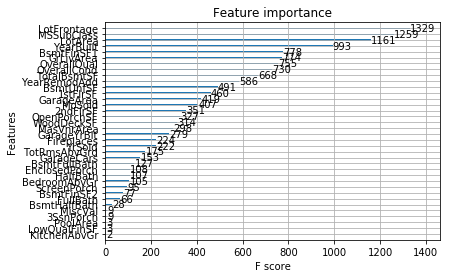

In [10]:
_ = xgb.plot_importance(xgb_model1)

## Examine monotonic behavior with partial dependence and ICE
* Partial dependence is used to view the global, average behavior of a variable under the monotonic model.
* ICE is used to view the local behavior of a single instance and single variable under the monotonic model.
* Overlaying partial dependence onto ICE in a plot is a convenient way to validate and understand both global and local monotonic behavior.

#### Helper function for calculating partial dependence

In [11]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas dataframe containing partial dependence for a single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: H2OFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which to calculate partial dependence.
    
    Returns:
        Pandas dataframe containing partial dependence values.
        
    """
    
    # don't show progress bars for parse
    h2o.no_progress()
    
    # init empty Pandas frame w/ correct col names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original data 
    col_cache = h2o.deep_copy(frame[xs], xid='col_cache')
  
    # determine values at which to calculate partial dependency
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependency  
    # by setting column of interest to constant 
    for j in bins:
        frame[xs] = j
        dframe = xgb.DMatrix(frame.as_data_frame(),)
        par_dep_i = h2o.H2OFrame(model.predict(dframe).tolist())
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame[xs] = h2o.get_frame('col_cache')

    return par_dep_frame


#### Calculate partial dependence for 3 important variables

In [12]:
par_dep_OverallCond = par_dep('OverallCond', valid[reals], xgb_model1)
par_dep_GrLivArea = par_dep('GrLivArea', valid[reals], xgb_model1)
par_dep_LotArea = par_dep('LotArea', valid[reals], xgb_model1)

#### Helper function for finding decile indices

In [13]:
def get_quantile_dict(y, id_, frame):

    """ Returns the percentiles of a column y as the indices for another column id_.
    
    Args:
        y: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of y.
        frame: H2OFrame containing y and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    quantiles_df = frame.as_data_frame()
    quantiles_df.sort_values(y, inplace=True)
    quantiles_df.reset_index(inplace=True)
    
    percentiles_dict = {}
    percentiles_dict[0] = quantiles_df.loc[0, id_]
    percentiles_dict[99] = quantiles_df.loc[quantiles_df.shape[0]-1, id_]
    inc = quantiles_df.shape[0]//10
    
    for i in range(1, 10):
        percentiles_dict[i * 10] = quantiles_df.loc[i * inc,  id_]

    return percentiles_dict


#### Calculate deciles of SaleProce

In [14]:
quantile_dict = get_quantile_dict('SalePrice', 'Id', valid)

#### Calculate values for ICE

In [15]:
bins_OverallCond = list(par_dep_OverallCond['OverallCond'])
bins_GrLivArea = list(par_dep_GrLivArea['GrLivArea'])
bins_LotArea = list(par_dep_LotArea['LotArea'])

for i in sorted(quantile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    par_dep_OverallCond[col_name] = par_dep('OverallCond', 
                                            valid[valid['Id'] == int(quantile_dict[i])][reals], 
                                            xgb_model1, 
                                            bins=bins_OverallCond)['partial_dependence']
    
    par_dep_GrLivArea[col_name] = par_dep('GrLivArea', 
                                          valid[valid['Id'] == int(quantile_dict[i])][reals], 
                                          xgb_model1, 
                                          bins=bins_GrLivArea)['partial_dependence']
    
    par_dep_LotArea[col_name] = par_dep('LotArea', 
                                         valid[valid['Id'] == int(quantile_dict[i])][reals], 
                                         xgb_model1, 
                                         bins=bins_LotArea)['partial_dependence']

#### Plot Partial Dependence and ICE

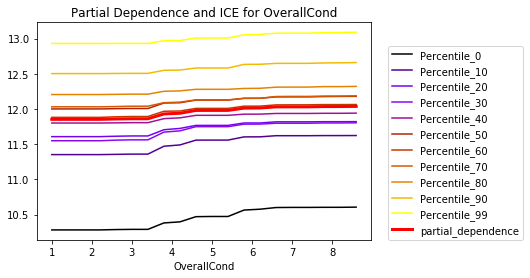

In [16]:
# OverallCond

fig, ax = plt.subplots()
par_dep_OverallCond.drop('partial_dependence', axis=1).plot(x='OverallCond', colormap='gnuplot', ax=ax)

par_dep_OverallCond.plot(title='Partial Dependence and ICE for OverallCond',
                         x='OverallCond', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

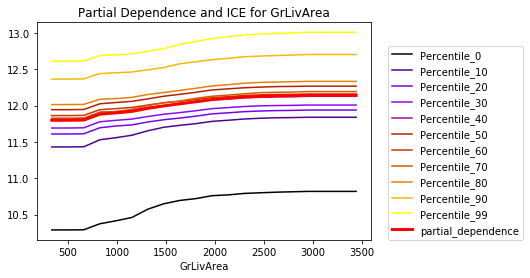

In [17]:
# GrLivArea

fig, ax = plt.subplots()
par_dep_GrLivArea.drop('partial_dependence', axis=1).plot(x='GrLivArea', colormap='gnuplot', ax=ax)

par_dep_GrLivArea.plot(title='Partial Dependence and ICE for GrLivArea',
                         x='GrLivArea', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

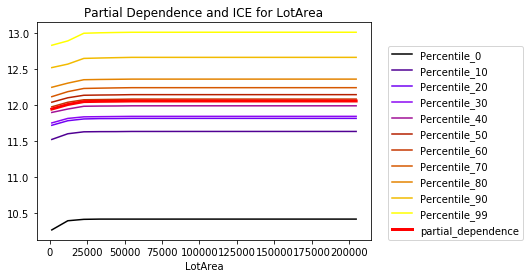

In [ ]:
# LotArea

fig, ax = plt.subplots()
par_dep_LotArea.drop('partial_dependence', axis=1).plot(x='LotArea', colormap='gnuplot', ax=ax)

par_dep_LotArea.plot(title='Partial Dependence and ICE for LotArea',
                     x='LotArea', 
                     y='partial_dependence',
                     style='r-', 
                     linewidth=3, 
                     ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

#### Shutdown H2O

In [ ]:
h2o.cluster().shutdown(prompt=True)